# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process, calc

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexandra/anaconda3/e

In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_test.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']
num_recount2_experiments = params['num_recount2_experiments_to_download']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_data_file = params['normalized_compendium_data_file']
shared_genes_file = params['shared_genes_file']
scaler_file = params['scaler_transform_file']

In [4]:
# Check if analysis output directory exist otherwise create
if not os.path.exists(local_dir):
    os.makedirs(local_dir, exist_ok=True)

In [5]:
# Read data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(template_data.shape)
assert(template_data.shape[0] == 24)
template_data.head()

(24, 17787)


,HSPA1L,FAM171B,SLC9C2,RAB3D,ZRANB2,TULP4,METTL18,SDK2,ZFYVE1,VIP,...,RMDN3,GFOD2,OR10J1,GAB1,DSCC1,KCNN2,SLC45A2,B4GALNT3,PADI1,PCDHA10
SRR493937,80,155,19,845,1348,1571,56,610,686,11,...,1672,1115,0,777,43,32,5,938,2,438
SRR493938,127,124,16,858,1381,1660,63,601,688,8,...,1689,1053,0,840,48,37,5,830,4,438
SRR493939,116,489,38,2066,1554,1689,130,508,698,4,...,1414,601,0,882,118,37,18,3723,59,784
SRR493940,116,482,41,2068,1558,1756,156,547,710,2,...,1409,584,0,963,105,47,3,3862,51,840
SRR493941,113,224,16,1764,2180,1152,106,592,1339,44,...,2112,1082,0,2496,81,75,4,807,0,837


### Normalize compendium 

In [6]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

print(original_compendium.shape)
original_compendium.head()

(92, 17787)


,HSPA1L,FAM171B,SLC9C2,RAB3D,ZRANB2,TULP4,METTL18,SDK2,ZFYVE1,VIP,...,RMDN3,GFOD2,OR10J1,GAB1,DSCC1,KCNN2,SLC45A2,B4GALNT3,PADI1,PCDHA10
SRR493816,147,113,1,2194,737,1099,94,136,2084,12,...,1299,1336,0,309,71,104,2,150,41,893
SRR493817,346,85,1,2046,621,1181,63,15,2597,2,...,1760,1029,0,375,109,26,0,267,27,787
SRR547975,15,587,0,105,3422,2542,244,0,655,0,...,1281,706,0,492,548,0,3,12,5,0
SRR547973,76,34,0,4529,1330,1814,295,8,438,0,...,616,594,0,958,249,0,0,501,16,215
SRR547968,143,5,0,2780,1984,2240,175,0,506,0,...,1242,855,0,855,797,4,25,237,55,5


In [7]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(92, 17787)


,HSPA1L,FAM171B,SLC9C2,RAB3D,ZRANB2,TULP4,METTL18,SDK2,ZFYVE1,VIP,...,RMDN3,GFOD2,OR10J1,GAB1,DSCC1,KCNN2,SLC45A2,B4GALNT3,PADI1,PCDHA10
SRR493816,0.215543,0.004453,0.021739,0.484206,0.098297,0.303546,0.230958,0.108367,0.802464,0.016925,...,0.564292,1.000000,0.0,0.054604,0.044710,0.347826,0.029412,0.013706,0.016374,0.440553
SRR493817,0.507331,0.003349,0.021739,0.451513,0.082741,0.326445,0.154791,0.011952,1.000000,0.002821,...,0.764553,0.770037,0.0,0.066498,0.068640,0.086957,0.000000,0.024397,0.010783,0.388259
SRR547975,0.021994,0.023130,0.000000,0.022752,0.458361,0.706507,0.599509,0.000000,0.252214,0.000000,...,0.556473,0.528090,0.0,0.087583,0.345088,0.000000,0.044118,0.001096,0.001997,0.000000
SRR547973,0.111437,0.001340,0.000000,1.000000,0.177819,0.503211,0.724816,0.006375,0.168656,0.000000,...,0.267593,0.444195,0.0,0.171562,0.156801,0.000000,0.000000,0.045779,0.006390,0.106068
SRR547968,0.209677,0.000197,0.000000,0.613651,0.265522,0.622173,0.429975,0.000000,0.194840,0.000000,...,0.539531,0.639700,0.0,0.153001,0.501889,0.013378,0.367647,0.021656,0.021965,0.002467


In [8]:
# Save data
original_data_scaled_df.to_csv(
    normalized_data_file, sep='\t')

# Save scaler transform
outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [9]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

input dataset contains 92 samples and 17787 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 83 samples, validate on 9 samples
Epoch 1/5
83/83 [==============================] - 22s 263ms/step - loss: 9178.1611 - val_loss: 37270.2782
Epoch 2/5
83/83 [==============================] - 21s 259ms/step - loss: 8204.0720 - val_loss: 12778.9877
Epoch 3/5
83/83 [==============================] - 21s 258ms/step - loss: 7965.6918 - val_loss: 9592.7716
Epoch 4/5
83/83 [==============================] - 22s 259ms/step - loss: 7982.1812 - val_loss: 9343.4266
Epoch 5/5
83/83 [==============================] - 22s 259ms/step - loss: 7883.8055 - val_loss: 8527.4518


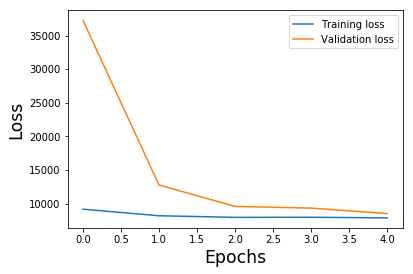

In [10]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_file,
                            normalized_data_file)

In [11]:
# Test reproducibility
template_path = "data/test_vae_logs.tsv"
output_path = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert np.all(np.isclose(
    pd.read_csv(output_path, sep="\t").values,
    pd.read_csv(template_path, sep="\t").values
    ))